In [27]:
import os
from google import genai
from getpass import getpass
import sqlite3
import pandas as pd
import json
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

In [28]:
root_path = Path('..')
data_path = root_path / "data"
chinook_db_path = data_path / "chinook.db"

In [30]:
DB_PATH = chinook_db_path
DB_TYPE = "sqlite"

---

# Generic overview

In [55]:
def sql_describe_clean(db, table):
    con = sqlite3.connect(db)
    cur = con.cursor()

    # Get columns
    cur.execute(f"PRAGMA table_info({table});")
    columns = cur.fetchall()

    results = {}

    for cid, name, dtype, *_ in columns:
        if dtype.upper() in ("INTEGER", "REAL", "NUMERIC", "FLOAT", "DOUBLE"):
            # Numeric stats
            q = f"""
                SELECT
                    COUNT([{name}]) AS count,
                    MIN([{name}]) AS min,
                    AVG([{name}]) AS mean,
                    MAX([{name}]) AS max
                FROM {table};
            """
            count, min_val, mean_val, max_val = cur.execute(q).fetchone()
            results[name] = {
                "count": count,
                "min": min_val,
                "mean": mean_val,
                "max": max_val,
                # object/text columns stats not applicable
                "unique": pd.NA,
                "top": pd.NA,
                "freq": pd.NA
            }
        else:
            # Text / object stats
            q = f"""
                SELECT
                    COUNT([{name}]) AS count,
                    COUNT(DISTINCT [{name}]) AS unique_count,
                    (SELECT [{name}] FROM {table}
                     GROUP BY [{name}]
                     ORDER BY COUNT(*) DESC
                     LIMIT 1) AS top_value,
                    (SELECT COUNT(*) FROM {table}
                     GROUP BY [{name}]
                     ORDER BY COUNT(*) DESC
                     LIMIT 1) AS top_freq
                FROM {table};
            """
            count, unique_count, top_value, top_freq = cur.execute(q).fetchone()
            results[name] = {
                "count": count,
                "min": pd.NA,
                "mean": pd.NA,
                "max": pd.NA,
                "unique": unique_count,
                "top": top_value,
                "freq": top_freq
            }

    # Convert results dict to DataFrame
    df = pd.DataFrame(results).T
    df.insert(0, "dtype", np.array(columns)[:,2])
    return df

describe = sql_describe_clean(DB_PATH, "employees")
describe


,dtype,count,min,mean,max,unique,top,freq
EmployeeId,INTEGER,8,1,4.5,8,<NA>,<NA>,<NA>
LastName,NVARCHAR(20),8,<NA>,<NA>,<NA>,8,Peacock,1
FirstName,NVARCHAR(20),8,<NA>,<NA>,<NA>,8,Steve,1
Title,NVARCHAR(30),8,<NA>,<NA>,<NA>,5,Sales Support Agent,3
ReportsTo,INTEGER,7,1,2.857143,6,<NA>,<NA>,<NA>
BirthDate,DATETIME,8,<NA>,<NA>,<NA>,8,1973-08-29 00:00:00,1
HireDate,DATETIME,8,<NA>,<NA>,<NA>,7,2003-10-17 00:00:00,2
Address,NVARCHAR(70),8,<NA>,<NA>,<NA>,8,923 7 ST NW,1
City,NVARCHAR(40),8,<NA>,<NA>,<NA>,3,Calgary,5
State,NVARCHAR(40),8,<NA>,<NA>,<NA>,1,AB,8


# Dynamic analysis

In [29]:
load_dotenv()
if 'GOOGLE_API_KEY' not in os.environ:
  os.environ['GOOGLE_API_KEY'] = getpass("Enter your OpenAI API key: ")
else:
  print("Using existing OpenAI API key")

Using existing OpenAI API key


In [31]:
def export_schema(db_path: str) -> str:
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    cur.execute("SELECT sql FROM sqlite_master WHERE type='table'")
    return "\n".join(row[0] for row in cur.fetchall())

schema = export_schema(DB_PATH)
print(schema[:250], '\n...')

CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UP 
...


In [32]:
client = genai.Client()

In [174]:
# https://www.sqlitetutorial.net/sqlite-sample-database/ # data structure reference
# question = input()
question = "Give me a count of employees grouped by age?"
question = "What are the top 10 most used genres?"
question = "Which genre generated the highest revenue?" # one with no plot
question = "Which genre generated the highest revenue? What are the top 5 genres by revenue?"
question = "What are the revenues and the number of tracks sold for each genre?" # 2 plots
question = "How many tracks does top 5 artist have in each genre?"

In [175]:
prompt = f"""

```db-schema
{schema}
```

Hello, knowing the schema, propose me sql query that will answer this question: {question}

Note that i use {DB_TYPE}.

Please provide ONLY the sql query, nothing else.
"""

retries = 3
while retries > 0:
    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash-lite',
            contents=prompt
        )
        break
    except Exception as e:
        print(f"Error: {e}")
        retries -= 1
        if retries == 0:
            raise

query = response.text
if query.startswith("```sql"):
  query = query.split("```sql")[1].strip('`').strip()
print(query)

WITH RankedTracks AS (
  SELECT
    g.Name AS GenreName,
    ar.Name AS ArtistName,
    COUNT(t.TrackId) AS TrackCount,
    ROW_NUMBER() OVER (PARTITION BY g.Name ORDER BY COUNT(t.TrackId) DESC) AS rn
  FROM tracks AS t
  JOIN albums AS al
    ON t.AlbumId = al.AlbumId
  JOIN artists AS ar
    ON al.ArtistId = ar.ArtistId
  JOIN genres AS g
    ON t.GenreId = g.GenreId
  GROUP BY
    g.Name,
    ar.Name
)
SELECT
  GenreName,
  ArtistName,
  TrackCount
FROM RankedTracks
WHERE
  rn <= 5
ORDER BY
  GenreName,
  TrackCount DESC;


In [176]:
con = sqlite3.connect(DB_PATH)
df = pd.read_sql(query, con=con)
df.head()

,GenreName,ArtistName,TrackCount
0,Alternative,Chris Cornell,14
1,Alternative,Audioslave,14
2,Alternative,Temple of the Dog,10
3,Alternative,Calexico,1
4,Alternative,Cake,1


In [192]:
with open(data_path / 'df_plot_parameters.txt', 'r') as f:
    df_plot_parameters = f.read() \
        .replace('\n        ', ' - ') \
        .replace('\n\n    ', ' – ') \
        .replace('\n\n', '')
# print(df_plot_parameters)

In [197]:
plot_prompt = f"""

```df-plot-parameters
{df_plot_parameters}
```

```df-columns
{df.columns}
```

```df-index
{df.index}
```

```df-head
{df.head()}
```

Question: {question}

Hello, knowing the data and the question, prepare me parameters dictionary (json)
that will used for df.plot() as kwargs. Only use parameters from the df-plot-parameters that are relevant.

The plot needs to be nice and informative.
and it may be complex (e.g. hue, multiple subplots, grouped plots, stacked plots, etc) if needed.

Please provide ONLY the flat json, nothing else.

Additionally, add a 'should_plot' key with boolean value indicating whether plotting is appropriate for this data.
"""

# Use *Set2* colormap when you dont specify color (when you do, dont use *Set2*).

response = client.models.generate_content(
  model='gemini-2.5-flash-lite',
  contents=plot_prompt
)

params = response.text
if params.startswith("```json"):
  params = params.split("```json")[1]
params = params.strip('`').strip()
print(params)

{
  "kind": "bar",
  "subplots": true,
  "layout": [
    3,
    1
  ],
  "sharey": false,
  "title": "Top 5 Artists by Track Count per Genre",
  "ylabel": "Track Count",
  "xlabel": "Artist",
  "legend": true,
  "stacked": false,
  "figsize": [
    10,
    15
  ],
  "should_plot": true
}


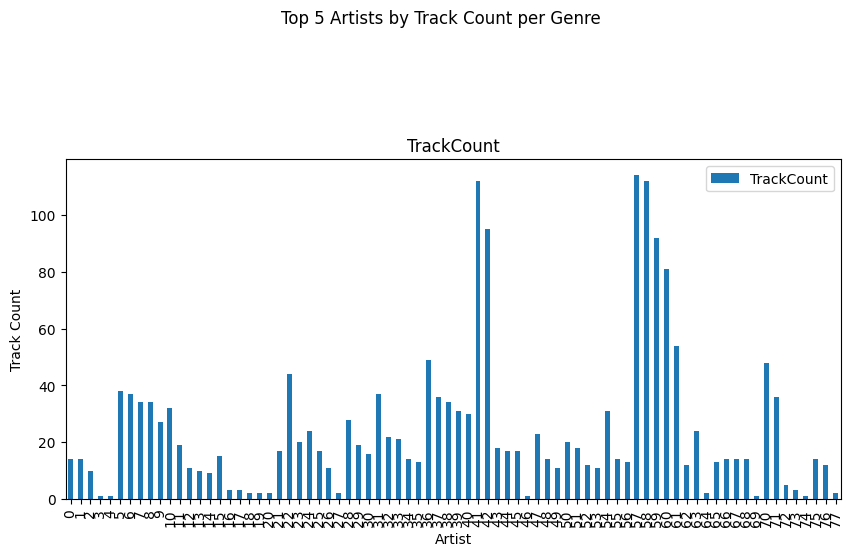

In [198]:
if '"should_plot": false' in params:
    print(df.to_markdown())
else:
    d = json.loads(params)
    d.pop("should_plot", None)
    df.plot(**d)